# Tutorial: Vizualizing the U-Net Model predictions


In [1]:
import numpy as np
import dask.array as da
import xarray as xr
import zarr

from os import path

import matplotlib.pyplot as plt

import tensorflow as tf
from keras import Input
import keras.layers as layers
from keras.callbacks import EarlyStopping

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mindthegap as mtg

2025-08-21 21:13:48.624791: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-21 21:13:48.638634: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-21 21:13:48.655792: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-21 21:13:48.661060: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-21 21:13:48.673656: I tensorflow/core/platform/cpu_feature_guar

### Reload trained model
If you want to reload a specific model, use `tf.kera.models.load_model` along with the path to the model.

In [7]:
import tensorflow as tf
zarr_label="2015_3_ArabSea"
model_name="UNet_DoubleConv_mse"
model = tf.keras.models.load_model(f'models/{zarr_label}/{model_name}.keras')

2025-08-21 21:16:07.912005: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


### Load the processed data

In [8]:
# vars
datafeatures = ['sst']
train_year = 2015
train_range = 3
val_range = 1
test_range = 1

In [9]:
import xarray as xr
import mindthegap as mtg
import zarr
datadir = "/home/jovyan/shared-public/mindthegap/data"
zarr_label="2015_3_ArabSea"
zarr_stdized = xr.open_zarr(f'{datadir}/{zarr_label}.zarr')
ds_cropped = mtg.crop_to_multiple(zarr_stdized, multiple=8)
ds_cropped

<xarray.Dataset> Size: 17GB
Dimensions:          (time: 16071, lat: 104, lon: 152)
Coordinates:
  * lat              (lat) float32 416B 31.0 30.75 30.5 30.25 ... 5.75 5.5 5.25
  * lon              (lon) float32 608B 42.0 42.25 42.5 ... 79.25 79.5 79.75
  * time             (time) datetime64[ns] 129kB 1979-01-01 ... 2022-12-31
Data variables:
    CHL              (time, lat, lon) float32 1GB dask.array<chunksize=(100, 104, 152), meta=np.ndarray>
    cos_time         (time, lat, lon) float32 1GB dask.array<chunksize=(100, 104, 152), meta=np.ndarray>
    fake_cloud_flag  (time, lat, lon) float64 2GB dask.array<chunksize=(100, 104, 152), meta=np.ndarray>
    land_flag        (time, lat, lon) float64 2GB dask.array<chunksize=(100, 104, 152), meta=np.ndarray>
    masked_CHL       (time, lat, lon) float32 1GB dask.array<chunksize=(100, 104, 152), meta=np.ndarray>
    next_day-CHL     (time, lat, lon) float64 2GB dask.array<chunksize=(100, 104, 152), meta=np.ndarray>
    prev_day_CHL     (time, lat, lon) float64 2GB dask.array<chunksize=(100, 104, 152), meta=np.ndarray>
    real_cloud_flag  (time, lat, lon) float64 2GB dask.array<chunksize=(100, 104, 152), meta=np.ndarray>
    sin_time         (time, lat, lon) float32 1GB dask.array<chunksize=(100, 104, 152), meta=np.ndarray>
    sst              (time, lat, lon) float32 1GB dask.array<chunksize=(100, 104, 152), meta=np.ndarray>
    valid_CHL_flag   (time, lat, lon) float64 2GB dask.array<chunksize=(100, 104, 152), meta=np.ndarray>

## Load original data
Need for plotting.

In [10]:
import xarray as xr
zarr_ds = xr.open_dataset(
    "gcs://nmfs_odp_nwfsc/CB/mind_the_chl_gap/IO.zarr",
    engine="zarr",
    backend_kwargs={"storage_options": {"token": "anon"}},
    consolidated=True
)
lat_min, lat_max = 5, 31
lon_min, lon_max = 42, 80

import numpy as np
zarr_ds = zarr_ds.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min,lon_max))  # choose long and lat
zarr_ds = mtg.crop_to_multiple(zarr_ds, multiple=8)
zarr_ds

<xarray.Dataset> Size: 25GB
Dimensions:                       (time: 16071, lat: 104, lon: 152)
Coordinates:
  * lat                           (lat) float32 416B 31.0 30.75 ... 5.5 5.25
  * lon                           (lon) float32 608B 42.0 42.25 ... 79.5 79.75
  * time                          (time) datetime64[ns] 129kB 1979-01-01 ... ...
Data variables: (12/27)
    CHL                           (time, lat, lon) float32 1GB ...
    CHL_cmes-cloud                (time, lat, lon) uint8 254MB ...
    CHL_cmes-gapfree              (time, lat, lon) float32 1GB ...
    CHL_cmes-land                 (lat, lon) uint8 16kB ...
    CHL_cmes-level3               (time, lat, lon) float32 1GB ...
    CHL_cmes_flags-gapfree        (time, lat, lon) float32 1GB ...
    ...                            ...
    ug_curr                       (time, lat, lon) float32 1GB ...
    v_curr                        (time, lat, lon) float32 1GB ...
    v_wind                        (time, lat, lon) float32 1GB ...
    vg_curr                       (time, lat, lon) float32 1GB ...
    wind_dir                      (time, lat, lon) float32 1GB ...
    wind_speed                    (time, lat, lon) float32 1GB ...
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L3_MY_009_103
    ...                              ...
    time_coverage_end:               2024-04-18T02:58:23Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-04-16T21:12:05Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l3-mult...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0

#### Function: `data_split`
This function selects the train, validation, and test data from the standardized data and splits the features and label.
##### Parameters:
- `zarr_stdized`: Zarr file storing standardized features and label.
- `train_year`: the first year of train data
- `train_range`: length of train data in year
- `val_range`: length of validation data in year
- `test_range`: length of test data in year
##### Return:
- `X_train, X_val, X_test`: the predictor variables of the train/validation/test data
- `y_train, y_val, y_test`: the response variables of the train/validation/test data

#### Model training
We use `tf.data.Dataset.from_tensor_slices()` to shuffle the train data and slice the train and validation data according the provided batch size.
We then define earlystopping that will stop the training process if the performance is not improving, and then start fitting the model. The MSE and MAE are printed for each training epoch, and their values are recorded by `history`.

#### Visualize losses
__Function__ `plot_losses`: Takes history as a parameter and plots the train and validation errors vs number of epochs (number of iterations for model training). This model evaluates the mean squared error and mean absolute error. 

In [22]:
def plot_losses(history):
    history_keys = list(history.history.keys())
    plot_num = len(history_keys) // 2
    plt.figure(figsize=(5 * plot_num, 4))
    for i in range(plot_num):
        plt.subplot(1, plot_num, i + 1)
        train_key = history_keys[i]
        val_key = history_keys[i + plot_num]
        plt.plot(history.history[train_key], label=f'Train {train_key}')
        plt.plot(history.history[val_key], label=f'Validation {val_key[4:]}')
        plt.title(train_key)
        plt.xlabel('Epoch')
        plt.ylabel(train_key)
        plt.legend(loc='upper right')
        plt.grid(True)
    plt.show()

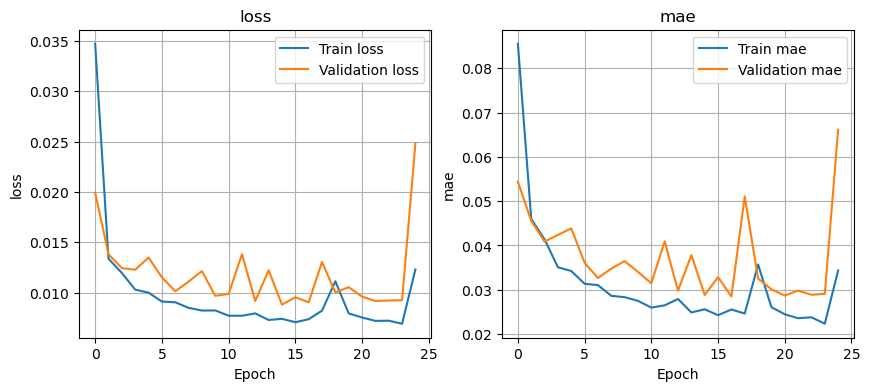

In [23]:
plot_losses(history)

### 4. Model Evaluation
#### Evaluate test losses
__Function `test_loss`__: Takes the model and the test dataset as parameters and evaluates the model's performance. We use `model.evaluate` for performance of the model on unseen (test) dataset. The evaluation process calculates all loss and metrics compiled to the model (MAE and MSE in this case).

In [27]:
def test_loss(X_test, y_test, model, print_loss=True):
    # Prepare test dataset
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    test_dataset = test_dataset.batch(4)

    # Evaluate the model on the test dataset
    test_mse, test_mae = model.evaluate(test_dataset)
    if print_loss:
        print(f"Test MSE: {test_mse}")
        print(f"Test MAE: {test_mae}")
    return test_mse, test_mae

In [28]:
test_mse, test_mae = test_loss(X_test, y_test, model)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0110 - mae: 0.0375
Test MSE: 0.010837583802640438
Test MAE: 0.03541838377714157


#### Helper functions in mindthegap
- `unstdize`: unstandardize a given image to the original distribution. Since we standardized all data before training, the predicted log(Chl-a) from the model is also standardized. We apply this function so that the predictions are more comparable to the observed and other gap-filling products.
- `compute_mae`: computes the mean absolute error between two nd-arrays with the same shape. We use this function to calculate the difference between observed and predicted, or predictions between different algorithms.
- `compute_mse`: similar to `compute_mae`, but calculates the mean squared error instead.

## Plot predictions
- `plot_prediction_observed`: predicts the observed log(chl-a) data of a given date. Plots a four-panel plot with the top left being the log observed data, top right being the flag, bottom left being the log prediction, and bottom right being the log difference. Log difference shows the percentage difference: blue/log(1) means the observed is about 2.7 times the prediction, red/log(-1) means the observed is about 37% of the prediction.

In [11]:
def plot_prediction_observed(zarr_stdized, zarr_label, model, date_to_predict):
    mean_std = np.load(f'{datadir}/{zarr_label}.npy',allow_pickle='TRUE').item()
    mean, std = mean_std['CHL'][0], mean_std['CHL'][1]
    zarr_date = zarr_stdized.sel(time=date_to_predict)
    X = []
    X_vars = list(zarr_stdized.keys())
    X_vars.remove('CHL')
    for var in X_vars:
        var = zarr_date[var].to_numpy()
        X.append(np.where(np.isnan(var), 0.0, var))
    X = np.array(X)
    X = np.moveaxis(X, 0, -1)

    true_CHL = np.log(zarr_ds.sel(time=date_to_predict)['CHL_cmes-level3'].to_numpy())
    # true_CHL = unstdize(true_CHL, mean, std)
    fake_cloud_flag = zarr_date.fake_cloud_flag.to_numpy()
    masked_CHL = np.where(fake_cloud_flag == 1, np.nan, true_CHL)
    # masked_CHL = unstdize(masked_CHL, mean, std)
    predicted_CHL = model.predict(X[np.newaxis, ...], verbose=0)[0]
    predicted_CHL = predicted_CHL[:,:,0]
    predicted_CHL = unstdize(predicted_CHL, mean, std)
    predicted_CHL = np.where(np.isnan(true_CHL), np.nan, predicted_CHL)
    diff = true_CHL - predicted_CHL

    flag = np.zeros(true_CHL.shape)
    flag = np.where(zarr_date['land_flag'] == 1, 0, flag)
    flag = np.where(zarr_date['valid_CHL_flag'] == 1, 2, flag)
    flag = np.where(zarr_date['real_cloud_flag'] == 1, 0, flag)
    flag = np.where(zarr_date['fake_cloud_flag'] == 1, 1, flag)

    vmax = np.nanmax((true_CHL, predicted_CHL))
    vmin = np.nanmin((true_CHL, predicted_CHL))

    extent = [42, 101.75, -11.75, 32]
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    im0 = axes[0, 0].imshow(true_CHL, vmin=vmin, vmax=vmax, extent=extent, origin='upper', transform=ccrs.PlateCarree(), interpolation='nearest')
    axes[0, 0].add_feature(cfeature.COASTLINE)
    axes[0, 0].set_xlabel('longitude')
    axes[0, 0].set_ylabel('latitude')
    axes[0, 0].set_xticks(np.arange(42, 102, 10), crs=ccrs.PlateCarree())
    axes[0, 0].set_yticks(np.arange(-12, 32, 5), crs=ccrs.PlateCarree())
    axes[0, 0].set_title('Observed Level-3 log Chl-a', size=14)
    
    im1 = axes[0, 1].imshow(flag, extent=extent, origin='upper', transform=ccrs.PlateCarree())
    axes[0, 1].add_feature(cfeature.COASTLINE, color='white')
    axes[0, 1].set_xlabel('longitude')
    axes[0, 1].set_ylabel('latitude')
    axes[0, 1].set_xticks(np.arange(42, 102, 10), crs=ccrs.PlateCarree())
    axes[0, 1].set_yticks(np.arange(-12, 32, 5), crs=ccrs.PlateCarree())
    axes[0, 1].set_title('Land, Cloud, and Observed Flags After Applying Fake Cloud', size=13)
    
    im2 = axes[1, 0].imshow(predicted_CHL, vmin=vmin, vmax=vmax, extent=extent, origin='upper', transform=ccrs.PlateCarree(), interpolation='nearest') 
    axes[1, 0].add_feature(cfeature.COASTLINE, color='white')
    axes[1, 0].imshow(np.where(flag == 1, np.nan, flag), vmax=2, vmin=0, extent=extent, origin='upper', interpolation='nearest', alpha=1)
    axes[1, 0].set_xlabel('longitude')
    axes[1, 0].set_ylabel('latitude')
    axes[1, 0].set_xticks(np.arange(42, 102, 10), crs=ccrs.PlateCarree())
    axes[1, 0].set_yticks(np.arange(-12, 32, 5), crs=ccrs.PlateCarree())
    axes[1, 0].set_title('Predicted log Chl-a from U-Net', size=14)

    vmin2 = -1
    vmax2 = 1
    im3 = axes[1, 1].imshow(diff, vmin=vmin2, vmax=vmax2, extent=extent, origin='upper', transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu, interpolation='nearest')
    axes[1, 1].add_feature(cfeature.COASTLINE)
    axes[1, 1].set_xlabel('longitude')
    axes[1, 1].set_ylabel('latitude')
    axes[1, 1].set_xticks(np.arange(42, 102, 10), crs=ccrs.PlateCarree())
    axes[1, 1].set_yticks(np.arange(-12, 32, 5), crs=ccrs.PlateCarree())
    axes[1, 1].set_title('Difference Between log Observed and log Prediction\n(log observed - log prediction)', size=13)

    fig.subplots_adjust(right=0.76)
    cbar1_ax = fig.add_axes([0.79, 0.14, 0.025, 0.72])
    cbar1 = fig.colorbar(im0, cax=cbar1_ax)
    cbar1.ax.set_ylabel('log Chl-a (mg/m-3)', rotation=270, size=14, labelpad=16)

    cbar2_ax = fig.add_axes([0.86, 0.14, 0.025, 0.72])
    cbar2 = fig.colorbar(im1, cax=cbar2_ax)
    cbar2.ax.set_ylabel('land and real cloud = 0, fake cloud = 1, observed after masking = 2', rotation=270, size=14, labelpad=20)

    cbar3_ax = fig.add_axes([0.94, 0.14, 0.025, 0.72])
    cbar3 = fig.colorbar(im3, cax=cbar3_ax)
    cbar3.ax.set_ylabel('difference in log Chl-a', rotation=270, size=14, labelpad=16)
    plt.show()

In [12]:
date = '2020-09-08'
plot_prediction_observed(ds_cropped, zarr_label, model, date)

2025-08-21 21:18:54.635725: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-21 21:18:54.704474: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90300


NameError: name 'unstdize' is not defined

- `plot_prediction_gapfill`:  predicts the gapfilled log(chl-a) of a given date. Plots a four-panel plot with the top left being the log gapfilled data from Copernicus GlobColour gapfree product, top right being the log U-Net prediction, bottom left being the log difference, and bottom right being the absolute difference.

In [46]:
def plot_prediction_gapfill(zarr_stdized, zarr_label, model, date_to_predict):
    mean_std = np.load(f'{datadir}/{zarr_label}.npy',allow_pickle='TRUE').item()
    mean, std = mean_std['CHL'][0], mean_std['CHL'][1]
    zarr_date = zarr_stdized.sel(time=date_to_predict)
    X = []
    X_vars = list(zarr_stdized.keys())
    X_vars.remove('CHL')
    X_vars[X_vars.index('masked_CHL')] = 'CHL'
    X_vars[X_vars.index('real_cloud_flag')] = 'a'
    X_vars[X_vars.index('fake_cloud_flag')] = 'real_cloud_flag'
    X_vars[X_vars.index('a')] = 'fake_cloud_flag'
    
    for var in X_vars:
        var = zarr_date[var].to_numpy()
        X.append(np.where(np.isnan(var), 0.0, var))
    valid_CHL_ind = X_vars.index('valid_CHL_flag')
    X[valid_CHL_ind] = da.where(X[X_vars.index('fake_cloud_flag')] == 1, 1, X[valid_CHL_ind])
    X[X_vars.index('fake_cloud_flag')] = np.zeros(X[0].shape)
    X_masked_CHL = np.log(zarr_ds.sel(time=date_to_predict)['CHL_cmes-level3'].to_numpy())
    X_masked_CHL = (X_masked_CHL - da.full(X_masked_CHL.shape, mean_std['masked_CHL'][0])) / da.full(X_masked_CHL.shape, mean_std['masked_CHL'][1])
    X_vars[X_vars.index('CHL')] = X_masked_CHL

    
    X = np.array(X)
    X = np.moveaxis(X, 0, -1)

    true_CHL = np.log(zarr_ds.sel(time=date_to_predict)['CHL_cmes-gapfree'].to_numpy())
    masked_CHL = np.log(zarr_ds.sel(time=date_to_predict)['CHL_cmes-level3'].to_numpy())
    predicted_CHL = model.predict(X[np.newaxis, ...], verbose=0)[0]
    predicted_CHL = predicted_CHL[:,:,0]
    predicted_CHL = unstdize(predicted_CHL, mean, std)
    predicted_CHL = np.where(np.isnan(true_CHL), np.nan, predicted_CHL)
    log_diff = true_CHL - predicted_CHL
    diff = np.exp(true_CHL) - np.exp(predicted_CHL)

    vmax = np.nanmax((true_CHL, predicted_CHL))
    vmin = np.nanmin((true_CHL, predicted_CHL))

    extent = [42, 101.75, -11.75, 32]
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    im0 = axes[0, 0].imshow(true_CHL, vmin=vmin, vmax=vmax, extent=extent, origin='upper', transform=ccrs.PlateCarree())
    # axes[0, 0].add_feature(cfeature.COASTLINE)
    axes[0, 0].set_xlabel('longitude')
    axes[0, 0].set_ylabel('latitude')
    axes[0, 0].set_xticks(np.arange(42, 102, 10), crs=ccrs.PlateCarree())
    axes[0, 0].set_yticks(np.arange(-12, 32, 5), crs=ccrs.PlateCarree())
    axes[0, 0].set_title('Log Chl-a from the Gapfree \nLevel-4 GlobColour Copernicus Product', size=14)
    
    im1 = axes[0, 1].imshow(predicted_CHL, extent=extent, origin='upper', transform=ccrs.PlateCarree())
    axes[0, 1].set_xlabel('longitude')
    axes[0, 1].set_ylabel('latitude')
    axes[0, 1].set_xticks(np.arange(42, 102, 10), crs=ccrs.PlateCarree())
    axes[0, 1].set_yticks(np.arange(-12, 32, 5), crs=ccrs.PlateCarree())
    axes[0, 1].set_title('Gapfree log Chl-a from U-Net', size=14)
    
    vmax2 = 1
    vmin2 = -1
    im2 = axes[1, 0].imshow(log_diff, vmin=vmin2, vmax=vmax2, extent=extent, origin='upper', transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu)
    # axes[1, 0].add_feature(cfeature.COASTLINE)
    axes[1, 0].set_xlabel('longitude')
    axes[1, 0].set_ylabel('latitude')
    axes[1, 0].set_xticks(np.arange(42, 102, 10), crs=ccrs.PlateCarree())
    axes[1, 0].set_yticks(np.arange(-12, 32, 5), crs=ccrs.PlateCarree())
    axes[1, 0].set_title('Difference Between log Copernicus Product\nand log U-Net Prediction(log Copernicus - log U-Net)', size=13)

    im3 = axes[1, 1].imshow(diff, vmin=vmin2, vmax=vmax2, extent=extent, origin='upper', transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu)
    # axes[1, 1].add_feature(cfeature.COASTLINE)
    axes[1, 1].set_xlabel('longitude')
    axes[1, 1].set_ylabel('latitude')
    axes[1, 1].set_xticks(np.arange(42, 102, 10), crs=ccrs.PlateCarree())
    axes[1, 1].set_yticks(np.arange(-12, 32, 5), crs=ccrs.PlateCarree())
    axes[1, 1].set_title('Absolute Difference Between Copernicus Product\nand U-Net Predictions(Copernicus - U-Net)', size=13)

    # fig.subplots_adjust(right=0.85)
    # cbar_ax = fig.add_axes([0.88, 0.2, 0.03, 0.6])
    # fig.colorbar(im, cax=cbar_ax)

    # cbar2_ax = fig.add_axes([0.95, 0.2, 0.03, 0.6])
    # fig.colorbar(im2, cax=cbar2_ax)

    fig.subplots_adjust(right=0.85)
    cbar1_ax = fig.add_axes([0.87, 0.14, 0.025, 0.72])
    # .ax.set_ylabel('# of contacts', rotation=270)
    cbar1 = fig.colorbar(im0, cax=cbar1_ax)
    cbar1.ax.set_ylabel('log Chl-a (mg/m-3)', rotation=270, size=14, labelpad=16)

    cbar2_ax = fig.add_axes([0.94, 0.14, 0.025, 0.72])
    # .ax.set_ylabel('# of contacts', rotation=270)
    cbar2 = fig.colorbar(im2, cax=cbar2_ax)
    cbar2.ax.set_ylabel('difference in Chl-a in log or absolute scales', rotation=270, size=14, labelpad=16)
    plt.subplots_adjust(top=0.96)
    plt.show()

In [47]:
plot_prediction_gapfill(zarr_stdized, zarr_label, model, date)

2025-08-21 18:14:21.811610: W tensorflow/core/framework/op_kernel.cc:1840] OP_REQUIRES failed at xla_ops.cc:577 : INVALID_ARGUMENT: Cannot concatenate arrays that differ in dimensions other than the one being concatenated. Dimension 1 in both shapes must be equal (or compatible): f32[1,104,152,64] vs f32[1,105,153,10].
	 [[{{node U-net_1/concatenate_5_1/concat}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_111402[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
2025-08-21 18:14:21.811649: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Cannot concatenate arrays that differ in dimensions other than the one being concatenated. Dimension 1 in both shapes must be equal (or compatible): f32[1,104,152,64] vs f32[1,105,153,10].
	 [[{{node U-net_1/concatenate_5_1/concat}}]]
	tf2xla conversion failed while converting __inference

InvalidArgumentError: Graph execution error:

Detected at node U-net_1/concatenate_5_1/concat defined at (most recent call last):
<stack traces unavailable>
Cannot concatenate arrays that differ in dimensions other than the one being concatenated. Dimension 1 in both shapes must be equal (or compatible): f32[1,104,152,64] vs f32[1,105,153,10].
	 [[{{node U-net_1/concatenate_5_1/concat}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_111402[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_one_step_on_data_distributed_111505]

#### Plot Year-round Mean Absolute Difference
Such plots help evaluate the performance of the model on a daily basis and visualize seasonal trends.
- `yearly_MAD`: plots a line plot of the daily MAD between the observed and the U-Net prediction of the observed in a given year. 

In [14]:
def yearly_MAD(zarr_stdized, zarr_label, year):
    mean_std = np.load(f'{datadir}/{zarr_label}.npy',allow_pickle='TRUE').item()
    mean, std = mean_std['CHL'][0], mean_std['CHL'][1]
    time_range = slice(f'{year}-01-01', f'{year}-12-31')
    zarr_time_range = zarr_stdized.sel(time=time_range)

    mae = []

    X = []
    X_vars = list(zarr_stdized.keys())
    X_vars.remove('CHL')
    for var in X_vars:
        var = zarr_time_range[var].to_numpy()
        X.append(np.where(np.isnan(var), 0.0, var))
    X = np.array(X)
    X = np.moveaxis(X, 0, -1)

    true_CHL = np.log(zarr_ds.sel(time=time_range)['CHL_cmes-level3'].to_numpy())
    fake_cloud_flag = zarr_time_range.fake_cloud_flag.to_numpy()
    predicted_CHL = model.predict(X, verbose=0)
    predicted_CHL = predicted_CHL.reshape(predicted_CHL.shape[:-1])
    predicted_CHL = unstdize(predicted_CHL, mean, std)
    predicted_CHL = np.where(fake_cloud_flag == 0, np.nan, predicted_CHL)
    for true, pred in zip(true_CHL, predicted_CHL):
        mae.append(compute_mae(true, pred))
    
    fig, ax1 = plt.subplots()
    
    color = 'tab:red'
    ax1.set_xlabel('Month')
    ax1.set_ylabel('MAD of log (Globcolour l3) - log (U-Net)', color=color)
    ax1.plot(mae, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    tick_pos = []
    tick_label = []
    total_day = 1
    tick_pos.append(total_day + 15)
    tick_label.append('1')
    for month in range(1, 12):
        total_day += calendar.monthrange(year, month)[1]
        plt.axvline(total_day, color='grey', alpha=0.3)
        tick_pos.append(total_day + 15)
        tick_label.append(str(month+1))
    plt.title(f'Observed (Level-3) CHL vs U-Net Predictions Year {year}')
    plt.xlim(1, len(mae))
    plt.xticks(tick_pos, tick_label)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()


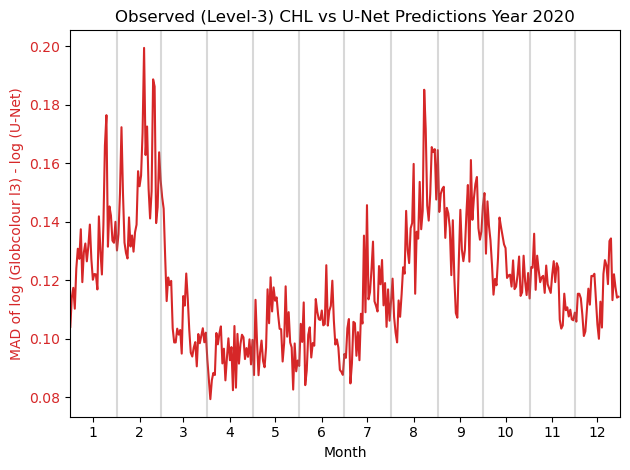

In [22]:
yearly_MAD(zarr_stdized, zarr_label, 2020)

- `yearly_MAD_vs_cloud`: plots a line plot with two lines: the red line is the daily MAD between the Copernicus Gapfree product and the U-Net's gapfree prediction in a given year, and the blue line is the daily percentage of cloud/missing data of the same year.
- `get_cloud_perc`: a helper function that gets the cloud percentage in a given year.|

In [23]:
def get_cloud_perc(zarr_stdized, year):
    zarr_time_range = zarr_stdized.sel(time=str(year))

    non_land_cnt = len(np.where(zarr_time_range['land_flag'][0] == 0)[0])
    clouds = zarr_time_range['real_cloud_flag'].data
    cloud_cnt = np.sum(clouds == 1, axis=(1, 2)).compute()
    cloud_perc = cloud_cnt / non_land_cnt

    return cloud_perc
    

def yearly_MAD_vs_cloud(zarr_stdized, zarr_label, model, year):
    mean_std = np.load(f'{datadir}/{zarr_label}.npy',allow_pickle='TRUE').item()
    mean, std = mean_std['CHL'][0], mean_std['CHL'][1]
    time_range = slice(f'{year}-01-01', f'{year}-12-31')

    zarr_time_range = zarr_stdized.sel(time=time_range)
    
    X = []
    X_vars = list(zarr_stdized.keys())
    X_vars.remove('CHL')
    X_vars[X_vars.index('masked_CHL')] = 'CHL'
    X_vars[X_vars.index('real_cloud_flag')] = 'a'
    X_vars[X_vars.index('fake_cloud_flag')] = 'real_cloud_flag'
    X_vars[X_vars.index('a')] = 'fake_cloud_flag'
    for var in X_vars:
        var = zarr_time_range[var].to_numpy()
        X.append(np.where(np.isnan(var), 0.0, var))
    valid_CHL_ind = X_vars.index('valid_CHL_flag')
    X[valid_CHL_ind] = da.where(X[X_vars.index('fake_cloud_flag')] == 1, 1, X[valid_CHL_ind]) 
    X[X_vars.index('fake_cloud_flag')] = np.zeros(X[0].shape)
    X_masked_CHL = np.log(zarr_ds.sel(time=time_range)['CHL_cmes-level3'].to_numpy())
    X_masked_CHL = (X_masked_CHL - da.full(X_masked_CHL.shape, mean_std['masked_CHL'][0])) / da.full(X_masked_CHL.shape, mean_std['masked_CHL'][1])
    X_vars[X_vars.index('CHL')] = da.where(da.isnan(X_masked_CHL), 0.0, X_masked_CHL)
    X = np.array(X)
    X = np.moveaxis(X, 0, -1)

    true_CHL = np.log(zarr_ds.sel(time=time_range)['CHL_cmes-gapfree'].to_numpy())            
    # fake_cloud_flag = zarr_date.fake_cloud_flag.to_numpy()
    predicted_CHL = model.predict(X, verbose=0)
    predicted_CHL = predicted_CHL.reshape(predicted_CHL.shape[:-1])
    predicted_CHL = unstdize(predicted_CHL, mean, std)
    flag = zarr_ds.sel(time=str(year))['CHL_cmes-level3'].to_numpy()
    predicted_CHL = np.where(~np.isnan(flag), np.nan, predicted_CHL)
    mae = []
    for true, pred in zip(true_CHL, predicted_CHL):
        mae.append(compute_mae(true, pred))
    
    cloud_perc = get_cloud_perc(zarr_stdized, year)
    
    fig, ax1 = plt.subplots()
    
    color = 'tab:red'
    ax1.set_xlabel('Month')
    ax1.set_ylabel('MAD of log (Globcolour l4) - log (U-Net)', color=color)
    ax1.plot(mae, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
    
    color = 'tab:blue'
    ax2.set_ylabel('Cloud Percentage', color=color)  # we already handled the x-label with ax1
    ax2.plot(cloud_perc, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    tick_pos = []
    tick_label = []
    total_day = 1
    tick_pos.append(total_day + 15)
    tick_label.append('1')
    for month in range(1, 12):
        total_day += calendar.monthrange(year, month)[1]
        plt.axvline(total_day, color='grey', alpha=0.3)
        tick_pos.append(total_day + 15)
        tick_label.append(str(month+1))
    plt.title(f'Copernicus GlobColour Gapfree CHL vs U-Net Predictions\nMAD vs Cloud Percentage Year {year}')
    plt.xlim(1, len(mae))
    plt.xticks(tick_pos, tick_label)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

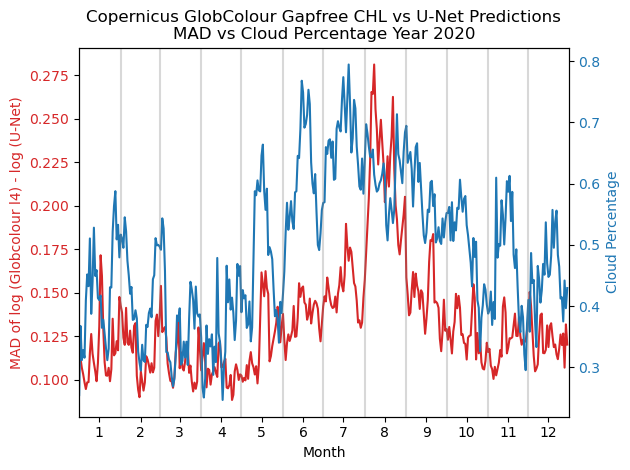

In [24]:
yearly_MAD_vs_cloud(zarr_stdized, zarr_label, model, 2020)